# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [19]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Task 1. Solution 
In this task we opted to first read all the data files pertaining to a specific country into their own DataFrames, and then after cleaning these values, aggregate the DataFrames into one. This singular DataFrame is later used for the required calculations.

In [20]:
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None

We created a function *read_files()* to read all *.csv* data files from a specific directory into a single DataFrame. The parameter *dirname* specifies the location of the files and *date_col* represents the variable to be passed to the [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) as the *parse_dates* parameter, which represents the columns that need to be parsed as *numpy.datetime64*.  
This function is used to merge all the daily reports found in the country-specific directories.

In [21]:
def read_files(dirname, date_col):
    temp = []
    for filename in os.listdir(DATA_FOLDER + dirname):
        df = pd.read_csv(DATA_FOLDER + dirname + filename, header=0, parse_dates = date_col)
        temp.append(df)
    return temp

The *format_data()* function has the following parameters:
 - *df* - the DataFrame from which we want to format the values
 - *idx* - the names of the columns that represent the index
 - *country* - the name of the country
 - *desc_col* - the name of the column that containts the detailed information about the case type
 - *date_col* - the name of the column that containts the date when the information was gathered
 - *contains* - character sequences to be passed to the *pandas.Series.str.contains*, in order to specify the key words in the description column that fit the specific use case
 - *n_contains* - character sequences to be passed to the *pandas.Series.str.contains*, in order to specify the key words in the description column that do not fit the specific use case 
 - *case* - the name of the use case
 - *cols_drop* - columns that we will ignore in the further steps.
 
We always use *cols_drop* to drop the columns that contain the sum of all the other numerical columns, as we determined that they were not always accurate.

In [22]:
def format_data(df, idx, country, desc_col, date_col, contains, n_contains, case, cols_drop):    
    df_new = df[(df[desc_col].str.contains(contains, case = False) == True) & 
          (df[desc_col].str.contains(n_contains, case = False) == False)]
    df_new['Country'] = country
    df_new['Case'] = case 
    df_new.rename(columns = {desc_col:'Description', date_col:'Date'}, inplace = True)
    df_new.set_index(keys = idx, inplace = True)
    df_new.drop(cols_drop, axis = 1, inplace = True)
    return df_new

We created an array *idx* that contains the names of the index columns that will be used for every country. Then we used [pandas.concat](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html) to place this data into the *g*,*l* and *sl* DataFrames, which represent Guinea, Liberia and Sierra Leone respectively.

In [23]:
idx = ['Country', 'Date', 'Case', 'Description']

g = pd.concat(read_files('\\ebola\\guinea_data\\', ['Date']))
l = pd.concat(read_files('\\ebola\\liberia_data\\', ['Date']))
sl = pd.concat(read_files('\\ebola\\sl_data\\', ['date']))

We created the *lgs_total* DataFrame that would later aggregate the data for all the countries.

In [24]:
lgs_total = pd.DataFrame(columns = idx) 
lgs_total.set_index(keys = idx, inplace =True)

Using the *format_data()* function we read the data for Guinea into the *g_new* and *g_deaths* DataFrames.
For new cases we used the rows described as:
 - New cases of suspects
 - New cases of probables
 - New cases of confirmed
 - New cases of confirmed among health workers
 - Number of confirmed cases among health workers
 - Number of probables cases among health workers
 - Number of suspects cases among health workers.
 
For deaths we used the row described as:
 - New deaths registered today
 - New deaths registered among health workers
 - Number of deaths of confirmed cases among health workers
 - Number of deaths of probables cases among health workers
 - Number of death of confirmed cases among health workers.
 
We concluded that the rows with the description: 
 - New deaths registered today (confirmed)
 - New deaths registered today (probables)
 - New deaths registered today (suspects)
not only are all contained in the *New deaths registered today* row, but also very rarely appear in the *.csv* files. 

Finally we merged them with the *lgs_total* DataFrame.
We repeated this process for Liberia and then Sierra Leone.

In [25]:
g_new = format_data(g, idx, 'Guinea', 'Description','Date', 'new|health worker',
                    'death|total|so far', 'New', 'Totals')
lgs_total = pd.merge(lgs_total, g_new, how='outer', left_index = True, right_index = True)

g_deaths = format_data(g, idx, 'Guinea', 'Description', 'Date', 'death',
                       'total|so far|\(', 'Death', 'Totals')
lgs_total = pd.merge(lgs_total, g_deaths, how='outer', left_index = True, right_index = True)

For Liberia we used the rows described as:
 - New Case/s (Suspected)
 - New Case/s (Probable)
 - New case/s (confirmed)
 - Newly Reported Cases in HCW

for new cases.
 
For deaths we used the row described as:
 - Newly reported deaths
 - Newly Reported deaths in HCW.

In [26]:
l_new = format_data(l, idx, 'Liberia', 'Variable', 'Date', 'new',
                    'deaths|total|so far|contacts|admissions', 'New', 'National')
lgs_total = pd.merge(lgs_total, l_new, how='outer', left_index = True, right_index = True)

l_deaths = format_data(l, idx, 'Liberia', 'Variable', 'Date', 'death',
                       'cumulative|total|so far|contacts|admissions', 'Death', 'National')
lgs_total = pd.merge(lgs_total, l_deaths, how='outer', left_index = True, right_index = True)

For Sierra Leone we used the rows described as:
 - new_suspected
 - new_probable
 - new_confirmed

for new cases.
 
For deaths we used the row described as:
 - death_suspected
 - death_probable
 - death_confirmed
 - etc_new_deaths.

In [27]:
sl_new = format_data(sl, idx, 'Sierra Leone', 'variable', 'date', 'new', 
                     'deaths|total|so far|contacts|admission|discharges|noncase', 'New', 'National')
lgs_total = pd.merge(lgs_total, sl_new, how='outer', left_index = True, right_index = True)

sl_deaths = format_data(sl, idx, 'Sierra Leone', 'variable', 'date', 'death', 
                     'total|so far|contacts|admission|discharges|noncase|cum', 'Death', 'National')
lgs_total = pd.merge(lgs_total, sl_deaths, how='outer', left_index = True, right_index = True)

Below is the DataFrame that contains all the relevant data from all the countries. It also contains all the regions of all the countries, but not the columns that represent sums.

In [28]:
lgs_total

Beyla_x  \
Country      Date       Case  Description                                                  
Guinea       2014-08-04 Death New deaths registered today                            NaN   
                              Number of death of confirmed cases among health...     NaN   
                              Number of deaths of confirmed cases among healt...     NaN   
                              Number of deaths of probables cases among healt...     NaN   
                        New   New cases of confirmed                                 NaN   
                              New cases of probables                                 NaN   
                              New cases of suspects                                  NaN   
                              Number of confirmed cases among health workers         NaN   
                              Number of probables cases among health workers         NaN   
                              Number of suspects cases among health workers          NaN   
             2014-08-26 Death New deaths registered                                  NaN   
                              New deaths registered among health workers             NaN   
                        New   New cases of confirmed                                 NaN   
                              New cases of confirmed among health workers            NaN   
                              New cases of probables                                 NaN   
                              New cases of suspects                                  NaN   
             2014-08-27 Death New deaths registered                                  NaN   
                              New deaths registered among health workers             NaN   
                        New   New cases of confirmed                                 NaN   
                              New cases of confirmed among health workers            NaN   
                              New cases of probables                                 NaN   
                              New cases of suspects                                  NaN   
             2014-08-30 Death New deaths registered                                  NaN   
                              New deaths registered among health workers             NaN   
                        New   New cases of confirmed                                 NaN   
                              New cases of confirmed among health workers            NaN   
                              New cases of probables                                 NaN   
                              New cases of suspects                                  NaN   
             2014-08-31 Death New deaths registered                                  NaN   
                              New deaths registered among health workers             NaN   
...                                                                                  ...   
Sierra Leone 2014-12-05 Death death_confirmed                                        NaN   
                              death_probable                                         NaN   
                              death_suspected                                        NaN   
                              etc_new_deaths                                         NaN   
                        New   new_confirmed                                          NaN   
                              new_negative                                           NaN   
                              new_positive                                           NaN   
                              new_probable                                           NaN   
                              new_samples                                            NaN   
                              new_suspected                                          NaN   
             2014-12-06 Death death_confirmed                                        NaN   
                              dea

To calculate the daily average per month of new cases and deaths, for each country we first needed to format the *lgs_total* DataFrame. We achieved this by setting all the null values to 0, then we applied the [pandas.to_numeric](http://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.to_numeric.html) to the DataFrame in order to make sure that all the values in all the columns were interpreted as numeric. After this we created a *Monthly Avg* column that contains the sum of all the values in each row. However at this moment this column really contains the sum of all the numerical values in each row. 

To get the monthly average we first dropped all columns except the *Monthly Avg* column. Then we sumed all the values, grouping them by date, country and case, to get the daily sum of all new cases or deaths. Finally we grouped these values by year, month, country and case, and retrieved the mean value.

For clarification we renamed the indexes accordingly.

In [29]:
lgs_total.fillna(0, inplace = True)
lgs_total = lgs_total.apply(pd.to_numeric, errors = 'coerce')
lgs_total['Monthly Avg'] =  lgs_total[list(lgs_total.columns)].sum(axis = 1)
lgs_total = lgs_total[['Monthly Avg']]

lgs_total = lgs_total.groupby(['Date','Country','Case']).sum()
lgs_total = lgs_total.groupby([ (lgs_total.index.get_level_values('Date').year), (lgs_total.index.get_level_values('Date').month), 
                               (lgs_total.index.get_level_values('Country')),(lgs_total.index.get_level_values('Case'))]).mean()

lgs_total.index.names = ['Year', 'Month', 'Country', 'Case']
lgs_total

Monthly Avg
Year Month Country      Case              
2014 6     Liberia      Death     2.000000
                        New       7.571429
     7     Liberia      Death     4.818182
                        New       9.181818
     8     Guinea       Death     7.200000
                        New      32.400000
           Liberia      Death    24.333333
                        New      38.111111
           Sierra Leone Death   379.600000
                        New      26.650000
     9     Guinea       Death     3.562500
                        New      19.750000
           Liberia      Death    36.666667
                        New      65.250000
           Sierra Leone Death   505.103448
                        New      42.827586
     10    Guinea       Death    15.000000
                        New      36.000000
           Liberia      Death    28.200000
                        New      46.840000
           Sierra Leone Death  1170.214286
                        New      71.928571
     11    Liberia      Death    13.666667
                        New      31.666667
           Sierra Leone Death  1150.285714
                        New      78.571429
     12    Liberia      Death     0.000000
                        New    5084.777778
           Sierra Leone Death  1607.600000
                        New      41.000000

From the above given data it is obvious that there is something **<font color=blue>f</font><font color=green>i</font><font color=blue>s</font><font color=green>h</font><font color=blue>y</font>** with the Sierra Leone deaths, and with all Liberia cases from 12/2014.

Upon closer inspection it became evident that the following row descriptions from Sierra Leone dataset actually represented cumulative values:
 - death_suspected
 - death_probable
 - death_confirmed,
 
while the *etc_new_deaths* values were not cumulative.

Because of this we decided to treat the Sierra Leone deaths separately. Below is the code that extracts them and does some minor formating.

In [30]:
sl_deaths = sl[(sl['variable'].str.contains('death', case = False) == True) & 
          (sl['variable'].str.contains('total|so far|contacts|admission|discharges|noncase|cum', case = False) == False)]
sl_deaths['Country'] = 'Sierra Leone'
sl_deaths.rename(columns = {'variable':'Description', 'date':'Date'}, inplace = True)

We seperated the *etc_new_deaths* values from the others.

In [31]:
etc = sl_deaths[ sl_deaths['Description'].str.contains('etc', case = False) == True]

Then we formatted the cumulative values found in the *death_suspected*, *death_probable* and *death_confirmed* rows.
As mentioned before, the columns that are meant to contain the sums are not always correct, therefore we dropped the *National* column and created our own *Total* column, which contains the sum of all other columns. Afterwards, we grouped the values by country and date, summing them into the *Total* column.

We overcame the difficulties that came with the cumulative values by first filling in all rows that had a *Total* value of zero with the value in the preceeding row. Finally we used the [pandas.DataFrame.diff](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) function to get the differences between the rows.

In [32]:
sl_deaths = sl_deaths[ sl_deaths['Description'].str.contains('etc', case = False) == False]
sl_deaths.set_index(keys = ['Country','Date', 'Description'], inplace = True)
sl_deaths.drop(['National'], axis = 1, inplace = True)
sl_deaths.fillna(0, inplace = True)
sl_deaths = sl_deaths.apply(pd.to_numeric, errors = 'coerce')
sl_deaths['Total'] =  sl_deaths[list(sl_deaths.columns)].sum(axis = 1)
sl_deaths = sl_deaths[['Total']]
sl_deaths = sl_deaths.groupby(['Country','Date']).sum()

for i in range(0, len(sl_deaths)):
    if (sl_deaths.iloc[i]['Total'] == 0):
        sl_deaths.iloc[i]['Total'] = sl_deaths.iloc[i - 1]['Total']
        
sl_deaths = sl_deaths.diff()

Then we formatted the *etc_new_deaths* values using the same operations that we used on the *death_suspected*, *death_probable* and *death_confirmed* values, but excluding the code that pertains to formatting the cumulative values.

In [33]:
etc.set_index(keys = ['Country','Date', 'Description'], inplace = True)
etc.drop(['National'], axis = 1, inplace = True)
etc.fillna(0, inplace = True)
etc = etc.apply(pd.to_numeric, errors = 'coerce')
etc['Total'] =  etc[list(etc.columns)].sum(axis = 1)
etc = etc[['Total']]
etc = etc.groupby(['Country','Date']).sum()

We then added the valued of the *Total* columns together. Then we sumed all the values, grouping them by date, country and case (death), to get the daily sum of all noncumulative deaths. Finally we grouped these values by year, month, country and case, and retrieved the mean value.

For clarification we renamed the indexes accordingly and renamed the *Total* column to *Monthly Avg*.

In [34]:
sl_deaths.fillna(0, inplace = True)
sl_deaths['Total'] = sl_deaths['Total'] + etc['Total']
sl_deaths['Case'] = 'Death'
sl_deaths = sl_deaths.groupby(['Date','Country','Case']).sum()
sl_deaths=sl_deaths.groupby([ (sl_deaths.index.get_level_values('Date').year), (sl_deaths.index.get_level_values('Date').month),
                             (sl_deaths.index.get_level_values('Country')), (sl_deaths.index.get_level_values('Case'))]).mean()
sl_deaths.rename(columns = {'Total':'Monthly Avg'}, inplace = True)
sl_deaths.index.names = ['Year', 'Month', 'Country', 'Case']
sl_deaths

Monthly Avg
Year Month Country      Case              
2014 8     Sierra Leone Death    12.150000
     9     Sierra Leone Death     9.172414
     10    Sierra Leone Death    32.785714
     11    Sierra Leone Death    20.761905
     12    Sierra Leone Death    42.400000

In the above DataFrame we can see that the values are no longer cumulative.

Following this clarification, we dropped the old values of the Sierra Leone deaths from the *lgs_total* DataFrame and afterwards concatenated the newly calculated Sierra Leone death values to the *lgs_total* DataFrame.

In [35]:
lgs_total = lgs_total[(lgs_total.index.get_level_values('Country') != 'Sierra Leone') | 
            (lgs_total.index.get_level_values('Case') != 'Death')]
lgs_total = pd.concat([lgs_total, sl_deaths])
lgs_total.sort_index(inplace= True)
lgs_total

Monthly Avg
Year Month Country      Case              
2014 6     Liberia      Death     2.000000
                        New       7.571429
     7     Liberia      Death     4.818182
                        New       9.181818
     8     Guinea       Death     7.200000
                        New      32.400000
           Liberia      Death    24.333333
                        New      38.111111
           Sierra Leone Death    12.150000
                        New      26.650000
     9     Guinea       Death     3.562500
                        New      19.750000
           Liberia      Death    36.666667
                        New      65.250000
           Sierra Leone Death     9.172414
                        New      42.827586
     10    Guinea       Death    15.000000
                        New      36.000000
           Liberia      Death    28.200000
                        New      46.840000
           Sierra Leone Death    32.785714
                        New      71.928571
     11    Liberia      Death    13.666667
                        New      31.666667
           Sierra Leone Death    20.761905
                        New      78.571429
     12    Liberia      Death     0.000000
                        New    5084.777778
           Sierra Leone Death    42.400000
                        New      41.000000

In the DataFrame above we can see that the Sierra Leone values are no longer so conspicuous. However, the Liberia cases from 12/2014 still stand out. Upon further inspection of the relevant *.csv* files we concluded that the December files for Liberia are missing lots of data, so we decided to exclude them in this last display. 

In [36]:
lgs_total = lgs_total[(lgs_total['Monthly Avg'] < 5000) & (lgs_total['Monthly Avg'] > 0)]
lgs_total

Monthly Avg
Year Month Country      Case              
2014 6     Liberia      Death     2.000000
                        New       7.571429
     7     Liberia      Death     4.818182
                        New       9.181818
     8     Guinea       Death     7.200000
                        New      32.400000
           Liberia      Death    24.333333
                        New      38.111111
           Sierra Leone Death    12.150000
                        New      26.650000
     9     Guinea       Death     3.562500
                        New      19.750000
           Liberia      Death    36.666667
                        New      65.250000
           Sierra Leone Death     9.172414
                        New      42.827586
     10    Guinea       Death    15.000000
                        New      36.000000
           Liberia      Death    28.200000
                        New      46.840000
           Sierra Leone Death    32.785714
                        New      71.928571
     11    Liberia      Death    13.666667
                        New      31.666667
           Sierra Leone Death    20.761905
                        New      78.571429
     12    Sierra Leone Death    42.400000
                        New      41.000000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

## Task 2. Solution

Firstly, in order to get metadata information for the single *DataFrame*, we had to import the data from the metadata *Excel* file. We defined that the *Barcode* column would be the index column of the metadata dataframe. The data from this column would be used to adress the corresponding spreadsheets in the later steps.

In [37]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

metadata = pd.read_excel(DATA_FOLDER + '\\microbiome\\metadata.xls', sheetname='Sheet1', index_col = 'BARCODE')
metadata.fillna('unknown', inplace = True)
metadata

,GROUP,SAMPLE
BARCODE,,
MID1,EXTRACTION CONTROL,unknown
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


Afterwards, we created a new empty dataframe named *samples* that would later be filled with the data from all the separate spreadsheets that contain the data concerning different samples. We wanted to create labels that precisely explain each column, so we also created an empty array *labels*, where we stored the appropiate values from rows of the *metadata* DataFrame. In the next step, we iterated through all the rows of *metadata* DataFrame and used the information we gained that way to retrieve data from separate spreadsheets about samples and merge it with *samples* DataFrame. We chose the outer join option for merging the tables because there are some bacterias that do not appear in every separate file, but we still want them in our final DataFrame.

In [38]:
samples = pd.DataFrame()
samples.index.names = ['Name']
labels = []

for index, row in metadata.iterrows():   
    mid = pd.read_excel(DATA_FOLDER + '\\microbiome\\'+index+'.xls', sheetname='Sheet 1', header=None, index_col= 0)
    labels.append([metadata.loc[index, 'GROUP'], metadata.loc[index, 'SAMPLE']])
    mid.columns = [index]
    mid.index.names = ['Name']
    samples = pd.merge(samples, mid, how='outer', left_index = True, right_index = True)

We formated the way of displaying the column labels by mapping the *labels* array to the columns of *samples* DataFrame and sorted them in alphabetical order. We also changed the way null values are represented in the DataFrame to the tag *unknown*.

In [39]:
samples.columns = list(map(list, zip(*labels))) 
samples = samples.reindex_axis(sorted(samples.columns), axis=1)
samples.columns.names = metadata.columns

samples.fillna('unknown', inplace = True)
samples

GROUP                                              Control 1           \
SAMPLE                                                 stool   tissue   
Name                                                                    
Archaea "Crenarchaeota" Thermoprotei Acidilobal...   unknown        1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...         1       15   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         8       14   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown  unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         2        4   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown        1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         1        1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...   unknown  unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         1        3   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...         1  unknown   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...         5        4   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...         3        2   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...         5        5   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...   unknown        3   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...   unknown        1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...        18        7   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...   unknown        4   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...   unknown        1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         1  unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         1  unknown   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         2        2   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...   unknown        1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...         2        1   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...         9  unknown   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...         2  unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown        3   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown        1   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown  unknown   
Archaea "Euryarchaeota" Halobacteria Halobacter...         3        3   
Archaea "Euryarchaeota" Halobacteria Halobacter...   unknown        2   
...                                                      ...      ...   
Bacteria "Proteobacteria" Gammaproteobacteria X...         5  unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...   unknown        1   
Bacteria "Proteobacteria" Gammaproteobacteria X...        80  unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...   unknown        1   
Bacteria "Proteobacteria" Gammaproteobacteria X...       133  unknown   
Bacteria "Proteobacteria" Gammaproteobacteria X...         1  unknown   
Bacteria "Spirochaetes" Spirochaetes Spirochaet...   unknown  unknown   
Bacteria "Synergistetes" Synergistia Synergista...         1        2   
Bacteria "Synergistetes" Synergistia Synergista...         8        3   
Bacteria "Synergistetes" Synergistia Synergista...   unknown  unknown   
Bacteria "Tenericutes" Mollicutes Anaeroplasmat...   unknown  unknown   
Bacteria "Tenericutes" Mollicutes Haloplasmatal...         2        2   
Bacteria "Thermodesulfobacteria" Thermodesulfob...         1  unknown   
Bacteria "Thermodesulfobacteria" Thermodesulfob...         3        1   
Bacteria "Thermotogae" Thermotogae Thermotogale...        15       12   
Bacteria "Thermotogae" Thermotogae Thermotogale...        16        7   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...         2        1   
Bacteria "Verrucomicrobia" Opitutae Opitutales ...       126        1   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...        39        1   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...         2  unknown   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...   unkno

In the end, we checked if all of the values of the index column *Name* have unique values and if there are any null values left in the DataFrame.

In [40]:
print(samples.index.is_unique)
print(samples.isnull().values.any())

True
False


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [41]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Task 3. Solution
<ul>
<li>[Question 1 solution](#q1)</li>
<li>[Question 2 solution](#q2)</li>
<li>[Question 3 solution](#q3)</li>
<li>[Question 4 solution](#q4)</li>
<li>[Question 5 solution](#q5)</li>
<li>[Question 6 solution](#q6)</li>
<li>[Question 2 solution - version 2](#q2v2)</li>
<li>[Question 3 solution - version 2](#q3v2)</li>
<li>[Question 5 solution - version 2](#q5v2)</li>
<li>[Question 6 solution - version 2](#q6v2)</li>
</ul>

Firstly, we imported the required libraries and set the custom color palette for plotting.

In [42]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
sns.set_context('notebook')
sns.set(style='darkgrid')
color_scheme = ["#F94867", "#70E041", "#FFD84B", "#5448BB", "#FF7089", "#9AFE70", "#FFE071", "#9083FD"]
sns.set_palette(sns.color_palette(color_scheme))
pd.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


<a id="q1"></a>
### Question 1
*Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical.*

In order to get the type and the value range of the numerical attributes we first used the [pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) function.

In [43]:
titanic = pd.read_excel(DATA_FOLDER + '\\titanic.xls', sheetname='titanic')
titanic.describe(percentiles = [], include=[np.number]).drop(['mean', 'std', '50%', 'count'])

,pclass,survived,age,sibsp,parch,fare,body
min,1.0,0.0,0.1667,0.0,0.0,0.0000,1.0
max,3.0,1.0,80.0000,8.0,9.0,512.3292,328.0


However, the [pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) function cannot describe the ranges of the non-numerical columns. We opted to create a separate DataFrame containing the *dtype*, *min* and *max* of each column.

In [44]:
titanic_types = pd.DataFrame(data = titanic.dtypes , index = titanic.columns, columns = ['dtype'] )
titanic_types['min'] = titanic.min()
titanic_types['max'] = titanic.max()
titanic_types

,dtype,min,max
pclass,int64,1,3
survived,int64,0,1
name,object,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
sex,object,female,male
age,float64,0.1667,80
sibsp,int64,0,8
parch,int64,0,9
ticket,object,NaN,NaN
fare,float64,0,512.329
cabin,object,NaN,NaN


The [categorical](https://pandas.pydata.org/pandas-docs/stable/categorical.html) data type is useful for string variables that consist of only a few different values. Converting to a categorical variable saves some memory.
We decided to apply this to the following columns:
 - sex
 - embarked
 - home.dest

The transformation of the last column is of little significance as this column is not used in later calculations, and has 369 different values.

In [45]:
#Run only ONCE -- column cannot be set as category more than once
titanic['sex'] = titanic['sex'].astype('category', categories = ['female', 'male'], ordered = False)
titanic['sex'].cat.codes.head()

0    0
1    1
2    0
3    1
4    0
dtype: int8

In [46]:
#Run only ONCE -- column cannot be set as category more than once
titanic['embarked'] = titanic['embarked'].astype('category', categories = ['S', 'C', 'Q'], ordered = True)
titanic['embarked'].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

In [47]:
#Run only ONCE -- column cannot be set as category more than once
titanic['home.dest'] = titanic['home.dest'].astype('category')
titanic['home.dest'].cat.codes.head()

0    308
1    230
2    230
3    230
4    230
dtype: int16

<a id="q2"></a>
### Question 2 
*Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.*

We created a function *plot_histogram()* that uses [seaborn.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html "seaborn.countplot documentation") to display the histogram for the selected column. Parameters *xticklabels*, *title*, *xlabel* and *ylabel* are there to beautify the histogram.

In [48]:
def plot_histogram(column, xticklabels, title, xlabel, ylabel):
    sns.countplot(titanic[column]).set(xticklabels = xticklabels,
                                       title = title,
                                       xlabel = xlabel,
                                       ylabel = ylabel)

In the first histogram, we named the passenger classes on the histogram as *First*, *Second* and *Third* and labeled the axes accordingly.

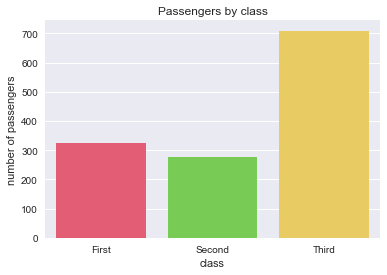

In [49]:
plot_histogram(column = 'pclass',
               xticklabels = ['First', 'Second', 'Third'],
               title = 'Passengers by class',
               xlabel = 'class',
               ylabel = 'number of passengers')

In the second histogram, using the information provided in *titanic.html* we named the boarding ports on the histogram as *Southhampton*, *Cherbourg* and *Queenstown* and labeled the axes accordingly.

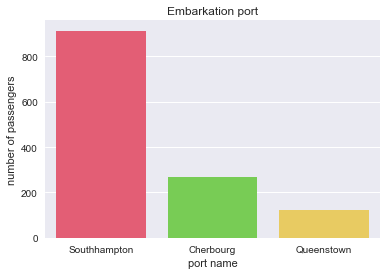

In [50]:
plot_histogram(column = 'embarked',
               xticklabels=['Southhampton', 'Cherbourg', 'Queenstown'],
               title='Embarkation port',
               xlabel='port name',
               ylabel = 'number of passengers')

In the third histogram, we named the sexes *Female* and *Male* and labeled the axes accordingly.

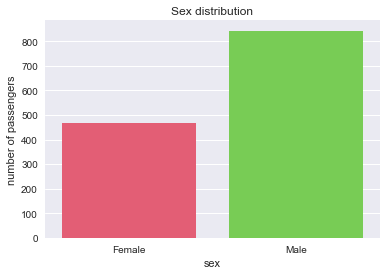

In [51]:
plot_histogram(column = 'sex',
               xticklabels=['Female', 'Male'],
               title='Sex distribution',
               xlabel='sex',
               ylabel = 'number of passengers')

<a id='q2-2'></a>
To divide the passengers into discrete decade categories we first had to calculate the maximum age and the decade it belongs to. We decided that the decades are **left inclusive** (eg. a person of 40.0 years of age belongs to the fifth decade [40-50)).

In [52]:
max_age = titanic['age'].max()
age_limit = max_age + (10 - max_age % 10) if max_age % 10 !=0 else (max_age + 20)
age_range = np.arange(0, age_limit, 10, dtype = np.int64)
age_range

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=int64)

<a id='q2-3'></a>
After that, we discretized the passengers' ages into their respective decades by using the [pandas.cut function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html "pandas.cut documentation") and plotted them with [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html "seaborn.distplot documentation").

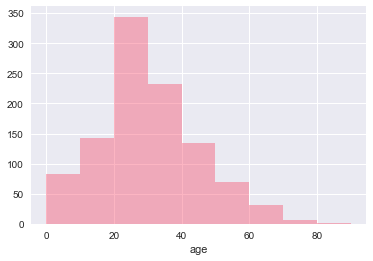

In [53]:
cut, bins = pd.cut(titanic.age, age_range, right=False, retbins = True)
sns.distplot(titanic.age.dropna(), kde=False, bins=bins, rug=False);

The passengers with missing age values were not plotted in this histogram and the way we tried to determine their age is described in [version 2 of the solution to question 2](#q2v2).

<a id="q3"></a>
### Question 3

*Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.*

To determine the distribution of passengers by cabin floors, we looked at the first letter of the passenger's cabin, according to the [Titanic deckplans](https://www.encyclopedia-titanica.org/titanic-deckplans/ "Titanic deckplans"). As a simplification, we removed the passengers with missing cabins. This usually isn't the best practice and we tried to solve this issue in the [version 2 of the solution to question 3](#q3v2). By plotting the values on a pie chart, we can observe the passenger distribution by floor.

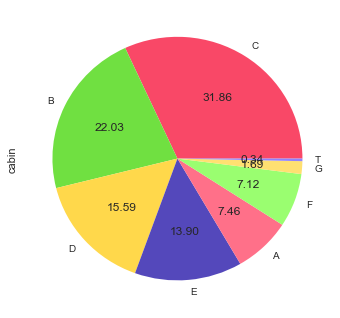

In [54]:
titanic_dropped_floors = titanic.dropna(subset = ['cabin'])

cabin_floors = titanic_dropped_floors.cabin.apply(lambda x: str(x).strip()[0])
cabin_floors.value_counts().plot.pie(figsize=(5.6, 5.6), autopct='%.2f');

For the cabins named for example: *F G63* we assumed that the passengers are on the floor designated by the first letter of the cabin name (*F* in this case) because most of the other passengers have multiple cabins reserved on their name which are on the same floor.

Sidenote: One may think that the passsenger in cabin T is an error because there is only one in the dataset, but according to [this article](https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html "Cabin T passenger"), there really was a cabin T on the *Boat deck* that did not belong to any other floors.

<a id="q4"></a>
### Question 4
*For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.*

To plot the survival rates, we defined a function *plot survival rates()* which selects the specific class and counts up the values of survived and died passengers for that class.
The results are afterwards displayed as a pie chart.

In [55]:
matplotlib.rcParams['font.size'] = 12
def plot_survival_rates(pclass, classname):
    titanic[titanic['pclass'] == pclass].survived.value_counts(sort = False).plot.pie(figsize=(6, 6),
                                                                 autopct='%.2f%%',
                                                                 labels = ['no', 'yes'],
                                                                 title=classname + ' class survival rates')

Survival rates for first class:

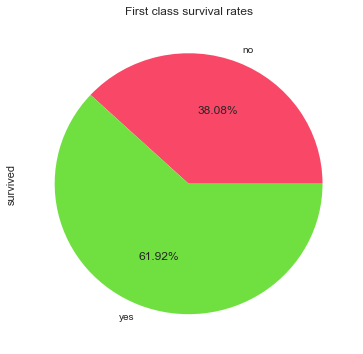

In [56]:
plot_survival_rates(1, 'First')

Survival rates for second class:

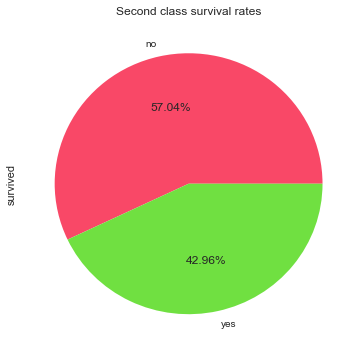

In [57]:
plot_survival_rates(2, 'Second')

Survival rates for third class:

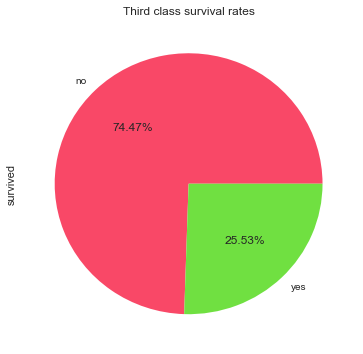

In [58]:
plot_survival_rates(3, 'Third')

<a id='q5'></a>
### Question 5
*Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.*

In order to calculate the proportion of the passengers that survived by travel class and sex we worked only with the columns *pclass*, *sex* and *survived*. We grouped the passengers by their class and sex and counted up the total number of passengers per class and sex. To calculate the survival percentage we summed up the survival outcome per class and sex and divided it by the total number of passengers per class and sex, and multiplied the results by 100.

In [59]:
passengers_survived = titanic.filter(['pclass', 'sex', 'survived'], axis=1)

survival_percentage = passengers_survived.groupby(['pclass', 'sex']).count()
survival_percentage['survived'] = passengers_survived.groupby(['pclass', 'sex'])['survived'].sum()/survival_percentage['survived']*100
survival_percentage

survived
pclass sex              
1      female  96.527778
       male    34.078212
2      female  88.679245
       male    14.619883
3      female  49.074074
       male    15.212982

After we obtained survival percentages we pivoted the dataframe by unstacking values in the sex column in order to display them on a single histogram.

survived           
sex        female       male
pclass                      
1       96.527778  34.078212
2       88.679245  14.619883
3       49.074074  15.212982

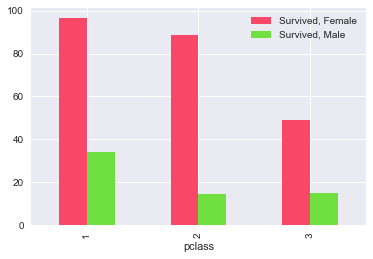

In [60]:
data = survival_percentage.unstack('sex')
graph = data.plot(kind='bar')
graph.legend(["Survived, Female", "Survived, Male"]);
data

Another interesting and similarly informative visualization of this DataFrame is the *heat map*, which we demonstrated in the [version 2 of the solution to this question](#q5v2).

<a id='q6'></a>
### Question 6
*Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.*

Firstly, we worked only with the columns *age*, *pclass*, *sex* and *survived*, which are required for this question. We also dropped several rows of the age column in which the values are missing. This isn't usually good practice and we tried to resolve that issue in [version 2 of the solution to question 6](#q6v2).

In [61]:
passengers_survived_groups = titanic.filter(['age', 'pclass', 'sex', 'survived'], axis=1).dropna(subset = ['age'])
passengers_survived_groups.head()

,age,pclass,sex,survived
0,29.0000,1,female,1
1,0.9167,1,male,1
2,2.0000,1,female,0
3,30.0000,1,male,0
4,25.0000,1,female,0


To divide the passengers into two (almost) equally populated age categories we used [pandas.qcut](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html "pandas.qcut documentation") function which by definition discretizes variables into equal-sized buckets based on rank or on sample quantiles.

In [62]:
cut, bins = pd.qcut(passengers_survived_groups.age, 2, labels=['younger than median', 'older than median'], retbins = True)

Afterwards, we renamed the age column to reflect the new meaning (division into two age categories). Lastly, we calculated the percentage the same way as in the [solution to question 5](#q5).

In [63]:
passengers_survived_groups.rename(columns = {'age': 'age category'}, inplace=True)
passengers_survived_groups['age category'] = cut

survival_groups_percentage = passengers_survived_groups.groupby(['age category', 'pclass', 'sex']).count()
survival_groups_percentage['survived'] = passengers_survived_groups.groupby(['age category', 'pclass', 'sex'])['survived'].sum()/survival_groups_percentage['survived']*100
survival_groups_percentage

survived
age category        pclass sex              
older than median   1      female  96.739130
                           male    30.252101
                    2      female  87.234043
                           male     8.333333
                    3      female  37.209302
                           male    14.400000
younger than median 1      female  95.121951
                           male    53.125000
                    2      female  91.071429
                           male    21.621622
                    3      female  51.376147
                           male    18.303571

<a id='q2v2'></a>
### Question 2 v2

Unfortunately, we can see that many passengers do not have their age set in the original DataFrame.

In [64]:
titanic['age'].isnull().sum()

263

 Therefore we tried to determine their ages by analyzing other columns in the table that might somehow hint their age. We noticed that each passenger's name contains a title (*Miss*, *Master*, *Mrs*, *Mr*...) that the person held. By looking at the title, we could set the age of the person to the mean age of all persons with known age who held the same title.

In [65]:
#extract the titles from passengers' names
titles = titanic.name.apply(lambda x: re.split('[,.]',x)[1].strip())

#create a new DataFrame with the passenger's title and their corresponding age
agecalc = pd.concat([titles, titanic.age], axis=1)
agecalc.columns = ['title', 'age']

#display the DataFrame; some of the later rows contain NaN values for age
agecalc

,title,age
0,Miss,29.0000
1,Master,0.9167
2,Miss,2.0000
3,Mr,30.0000
4,Mrs,25.0000
5,Mr,48.0000
6,Miss,63.0000
7,Mr,39.0000
8,Mrs,53.0000
9,Mr,71.0000


After creating the DataFrame with titles and ages for each person (where some of the ages are NaN), we created another DataFrame with all of the unique titles that occur in the *titanic* DataFrame.

In [66]:
unique_titles = titles.value_counts().index.to_series().reset_index().drop(0, axis=1)
unique_titles.columns = ['title']
unique_titles

,title
0,Mr
1,Miss
2,Mrs
3,Master
4,Rev
5,Dr
6,Col
7,Major
8,Ms
9,Mlle


We applied the function *make_age_good_again* on the *unique_titles* DataFrame in order to calculate the mean age of all the people that have the equivalent title. Simultaneously, as part of the function *fill_age_value*, for every row of the *agecalc* DataFrame where the age value is missing, we set the mean age value of passengers to that of their respective title.

In [67]:
#if age is NaN fill it with the mean age for that title
def fill_age_value(row, title, avg):
    if (pd.isnull(row.age) and row.title == title):
        row.age=avg
    return row.age

#for a specific title find the mean age of passengers with that title
#assign the calculated age to passengers with missing ages
def make_age_good_again(row):
    avg = agecalc[agecalc.title == row.title].mean()[0]
    agecalc.age = agecalc.apply(fill_age_value, args = [row.title, avg], axis=1)
    
unique_titles.apply(make_age_good_again, axis=1)

#create a new DataFrame in order to preserve the original
titanic_filled = titanic.copy()

#assign the titanic age column with new values
titanic_filled['age'] = agecalc['age']

The new DataFrame (titanic_filled) was created in order to preserve the original DataFrame.

We can now check if there are any missing age values.

In [68]:
titanic_filled['age'].isnull().sum()

0

Finally, we applied the same reasoning for distributing the passengers into discrete age categories as in the [original solution to this problem](#q2-3).

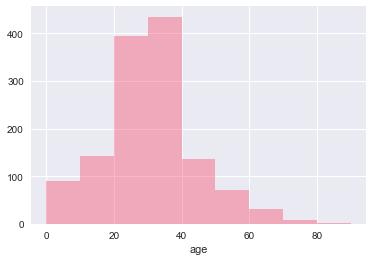

In [69]:
max_age = titanic_filled['age'].max()
age_limit = max_age + (10 - max_age % 10) if max_age % 10 !=0 else (max_age + 20)
age_range = np.arange(0, age_limit, 10, dtype = np.int64)
cut, bins = pd.cut(titanic_filled.age, age_range, right=False, retbins = True)
sns.distplot(titanic_filled.age.dropna(), kde=False, bins=bins, rug=False);

<a id='q3v2'></a>
### Question 3 v2

We can see that many passengers do not have their cabin (and cabin floor) set in the original DataFrame.

In [ ]:
titanic_filled['cabin'].isnull().sum()

We can also observe that most of the passengers with missing cabin floors are from the third class, which makes them grossly underrepresented in this statistic.

In [ ]:
titanic_filled.loc[titanic_filled['pclass'] == 3]['cabin'].isnull().sum()

To resolve this issue, we tried to determine the cabin floor of the passenger by looking at his or hers passenger class. We assigned the cabin to the passenger based on the normal distribution of cabin floors for the class of the observed passenger.



The function *class_test()* retrives the first letter of the cabin string for the selected row if the passenger is of the desired class, otherwise it returns NaN.

The function *floor_distribution()* simply applies the *class_test()* function to the desired DataFrame for the selected class.

The function *filter_results()* returns True if the selected row is of the desired class and the cabin value is not assigned.

The function *normalize_floors()* utilizes the above functions to create a DataFrame that has no null values in the cabin column for the selected class.

First we applied the *floor_distribution()* function in order to extract floors of the cabins for the selected class that are not null. Then we used the [pandas.Series.value_counts](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) to he relative frequencies of the unique floor values for that class.
We then applied the *filter_results()* function to get the passengers that are of the selected class but do not have cabins assigned to them. Afterwards we used the [numpy.random.choice](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html), which uses the previously calculated relative frequencies of the cabin floor values for the specified class, to fill out the missing cabin floor values for the other passengers in that class.

In [ ]:
def class_test(row, pclass):
    return str(row['cabin']).strip()[0] if row['pclass'] == pclass else NaN 

def floor_distribution(df, pclass):
    return df.apply(func =  class_test, args = [pclass], axis = 1).dropna()

def filter_results(row, pclass):
     return True if ((row['pclass'] == pclass) & (not row['cabin'])) else False

def normalize_floors(pclass, titanic_floors_missing,titanic_dropped_missing_floors ):
    chosen_class = floor_distribution(titanic_dropped_missing_floors[titanic_dropped_missing_floors.pclass == pclass], pclass)
    chosen_distribution = chosen_class.value_counts(normalize=True)
    chosen_missing = titanic_floors_missing.apply(func = filter_results, args = [pclass], axis = 1)
    chosen_class_with_floors = titanic_floors_missing.copy()
    chosen_class_with_floors.loc[chosen_missing,'cabin'] = np.random.choice(chosen_distribution.index, 
                                                                            size=len(chosen_class_with_floors[chosen_missing]),
                                                                            p=chosen_distribution.values)
    return chosen_class_with_floors


The *normalize_floors()* function is applied to every class in turn, and the overall floor distribution is plotted on the following pie chart.

In [ ]:
#fill NaN values for cabins with empty strings
titanic_filled['cabin'].fillna('', inplace = True)

first_class = normalize_floors(1, titanic_filled, titanic_dropped_floors)
second_class = normalize_floors(2, first_class, titanic_dropped_floors)
third_class = normalize_floors(3, second_class, titanic_dropped_floors)
titanic_with_all_floors = third_class

cabin_floors1 = titanic_with_all_floors.cabin.apply(lambda x: str(x).strip()[0])
cabin_floors1.value_counts().plot.pie(figsize=(6, 6), autopct='%.2f');

We can now see that probably the most populated floors were F, E and G, compared to the C, B and D floors in the [original solution](#q3).

The same reasoning can be applied to fill the missing values for the embarkation port.

In [ ]:
# normalize embarked

def class_test_ports(row, pclass):
    return str(row['embarked']).strip()[0] if row['pclass'] == pclass else  NaN 

def port_distribution (df, pclass):
    return df.apply(func =  class_test_ports, args = [pclass], axis = 1).dropna()

def filter_results_ports (row, pclass):
     return True if ((row['pclass'] == pclass) & (pd.isnull(row['embarked']))) else False
    

def normalize_ports(pclass, titanic_ports_missing,titanic_dropped_missing_ports ):
    chosen_class = port_distribution(titanic_dropped_missing_ports[titanic_dropped_missing_ports.pclass == pclass], pclass)
    chosen_distribution = chosen_class.value_counts(normalize=True)
    chosen_missing = titanic_ports_missing.apply(func = filter_results_ports, args = [pclass], axis = 1)
    chosen_class_with_ports = titanic_ports_missing.copy()
    chosen_class_with_ports.loc[chosen_missing,'embarked'] = np.random.choice(chosen_distribution.index, 
                                                         size=len(chosen_class_with_ports[chosen_missing]),
                                                                            p=chosen_distribution.values)
    return chosen_class_with_ports

titanic_dropped_ports = titanic_with_all_floors.copy()
titanic_dropped_ports = titanic_dropped_ports.dropna(subset = ['embarked'])

first_class = normalize_ports(1, titanic_with_all_floors, titanic_dropped_ports)
second_class = normalize_ports(2, first_class, titanic_dropped_ports)
third_class = normalize_ports(3, second_class, titanic_dropped_ports)
titanic_with_all_ports = third_class

embarked_dist1 = titanic_with_all_ports.embarked.apply(lambda x: str(x).strip()[0])
embarked_dist1.value_counts().plot.pie(figsize=(6, 6), labels = ['Southhampton', 'Cherbourg', 'Queenstown']);

<a id='q5v2'></a>
### Question 5 v2
Here is the *heat map* representation of the data calculated for question 5.

In [ ]:
passengers_survived = titanic_filled.filter(['pclass', 'sex', 'survived'], axis=1)

#need to set as_index = False in order to plot the heat map correctly
survival_percentage = passengers_survived.groupby(['pclass', 'sex'], as_index=False).count()
passengers_survived = passengers_survived.groupby(['pclass', 'sex'], as_index=False).sum()
passengers_survived.survived = passengers_survived.survived/survival_percentage.survived*100

#pivot the Data Frame in order to make heat map plotting possible
survivals = passengers_survived.pivot(index = 'pclass', columns = 'sex', values='survived')
sns.heatmap(survivals, square = True, annot = True, fmt = '.2f', linewidths = '.5', cmap = 'Greens_r', vmin = 0, vmax = 100)
plt.rcParams["figure.figsize"] = [16,9]

<a id='q6v2'></a>
### Question 6 v2

Here is the solution to question 6 recalculated with ages previously filled in [version 2 of question 2](#q2v2). The solution steps are identical as in the [original solution to this question](#q6) but they now work on the modified DataFrame, *titanic_filled*, which contains age for every person.

In [ ]:
passengers_survived_groups = titanic_filled.filter(['age', 'pclass', 'sex', 'survived'], axis=1)

cut, bins = pd.qcut(passengers_survived_groups.age, 2, labels=['younger than median', 'older than median'], retbins = True)

passengers_survived_groups.rename(columns = {'age': 'age category'}, inplace=True)
passengers_survived_groups['age category'] = cut

survival_groups_percentage = passengers_survived_groups.groupby(['age category', 'pclass', 'sex']).count()
survival_groups_percentage['survived'] = passengers_survived_groups.groupby(['age category', 'pclass', 'sex'])['survived'].sum()/survival_groups_percentage['survived']*100
survival_groups_percentage